In [43]:
import pandas as pd
import numpy as np
data_rfe=pd.read_csv('norm_yanghe.csv')
data_rfe=np.array(data_rfe)
fea=data_rfe[:,:49]
target=data_rfe[:,49]
x_test=fea[:170,:]
y_test=target[:170]
x_train=fea[170:,:]
y_train=target[170:]

# SVM-RFE_RELIEF

In [44]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class rfe_relief_SVM:
    def __init__(self,x_train,y_train,c,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=c
        self.Gamma=gamma
    def featu_score(self,alpha,folds):
        #kf=KFold(n_splits=folds,shuffle=False)
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[j for j in range(featu_num)]
        i=featu_num
        aver_lis=[j for j in range(featu_num)]
        F_lis=[j for j in range(featu_num)]
        aver=mean(cross_val_score(estimator,x_train,y_train,scoring="accuracy",cv=folds,n_jobs=-1))
        aver_lis[i-1]=aver
        F1=mean(cross_val_score(estimator,x_train,y_train,scoring="f1",cv=folds,n_jobs=-1))
        F_lis[i-1]=F1
        while True:
            relief_score=(reliefF.reliefF(self.X_train[:,candi_fea],self.Y_train)).reshape(1,i)
            #print(relief_score)
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                #print(len(candi_fea_copy))
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            total_score=alpha*relief_score+(1-alpha)*np.array(rfe_score)
            #print(total_score)
            index_=np.argmin(total_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            i-=1
            aver=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
            aver_lis[i-1]=aver
            F_lis[i-1]=F1
            if i==1:
                break
        return aver_lis,F_lis
    def sele_feature(self,alpha,optim_featur_num):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[i for i in range(featu_num)]
        i=featu_num
        while True:
            if len(candi_fea)==optim_featur_num:
                return candi_fea
            relief_score=(reliefF.reliefF(self.X_train[:,candi_fea],self.Y_train)).reshape(1,i)
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                #print(len(candi_fea_copy))
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            total_score=alpha*relief_score+(1-alpha)*np.array(rfe_score)
            #print(total_score)
            index_=np.argmin(total_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            print(i)
            i-=1
            

In [45]:
rfe_relief_model=rfe_relief_SVM(x_train,y_train,0.2,0.1)

In [46]:
aver_mean_lis1,F_measure_lis1=rfe_relief_model.featu_score(0.15,5)
print(aver_mean_lis1,F_measure_lis1)

[0.7932486037893418, 0.7835560311080954, 0.7871313742888459, 0.7845803538806827, 0.7856007620439481, 0.7840701497990501, 0.775399290150843, 0.7759042747533795, 0.7718239469700923, 0.7718265567096403, 0.7748903909389843, 0.7662117020721332, 0.7595764392713606, 0.7529463959496842, 0.7539641943734015, 0.7478391356542616, 0.7437509786523305, 0.7427305704890651, 0.7366055117699253, 0.731498251474503, 0.725369278146041, 0.7263896863093063, 0.7171916592724046, 0.7146380291246934, 0.7131074168797954, 0.7177044730935852, 0.7156610470275067, 0.7187235763870765, 0.7110679054230388, 0.7064695443394748, 0.703409624719453, 0.7028955060284984, 0.6993240774570697, 0.6906506080693148, 0.6875867738399709, 0.6804295631295998, 0.6732880108565166, 0.6748186231014144, 0.6732854011169687, 0.6671629521373766, 0.6605302990761522, 0.659507281173339, 0.6574664648468083, 0.653379612714651, 0.6503196930946291, 0.6508325069158097, 0.6513466256067645, 0.654920663917741, 0.6564578005115089] [0.7919884887339176, 0.780

In [47]:
aver_mean_lis2,F_measure_lis2=rfe_relief_model.featu_score(0.25,5)
print(aver_mean_lis2,F_measure_lis2)

[0.7932486037893418, 0.7835560311080954, 0.7871313742888459, 0.7845803538806827, 0.7835625554569654, 0.7779555300381022, 0.775399290150843, 0.7759042747533795, 0.7718239469700923, 0.7718265567096403, 0.7748903909389843, 0.7662117020721332, 0.7595764392713606, 0.7529463959496842, 0.7539641943734015, 0.7478391356542616, 0.7437509786523305, 0.7427305704890651, 0.7366055117699253, 0.731498251474503, 0.725369278146041, 0.7263896863093063, 0.7171916592724046, 0.7146380291246934, 0.7131074168797954, 0.7177044730935852, 0.7156610470275067, 0.7187235763870765, 0.7110679054230388, 0.7064695443394748, 0.703409624719453, 0.7028955060284984, 0.6993240774570697, 0.6906506080693148, 0.6875867738399709, 0.6804295631295998, 0.6732880108565166, 0.6748186231014144, 0.6732854011169687, 0.6671629521373766, 0.6605302990761522, 0.659507281173339, 0.6574664648468083, 0.653379612714651, 0.6503196930946291, 0.6508325069158097, 0.6513466256067645, 0.654920663917741, 0.6564578005115089] [0.7919884887339176, 0.780

In [48]:
aver_mean_lis3,F_measure_lis3=rfe_relief_model.featu_score(0.35,5)
print(aver_mean_lis3,F_measure_lis3)

[0.7932486037893418, 0.7835560311080954, 0.7871313742888459, 0.7845803538806827, 0.7835625554569654, 0.7779555300381022, 0.775399290150843, 0.7759042747533795, 0.7718239469700923, 0.7718265567096403, 0.7748903909389843, 0.7662117020721332, 0.7595764392713606, 0.7529463959496842, 0.7539641943734015, 0.7478391356542616, 0.7437509786523305, 0.7427305704890651, 0.7366055117699253, 0.731498251474503, 0.725369278146041, 0.7263896863093063, 0.7171916592724046, 0.7146380291246934, 0.7131074168797954, 0.7177044730935852, 0.7156610470275067, 0.7187235763870765, 0.7110679054230388, 0.7064695443394748, 0.703409624719453, 0.7028955060284984, 0.6993240774570697, 0.6906506080693148, 0.6875867738399709, 0.6804295631295998, 0.6732880108565166, 0.6748186231014144, 0.6732854011169687, 0.6671629521373766, 0.6605302990761522, 0.659507281173339, 0.6574664648468083, 0.653379612714651, 0.6503196930946291, 0.6508325069158097, 0.6513466256067645, 0.654920663917741, 0.6564578005115089] [0.7919884887339176, 0.780

In [49]:
aver_mean_lis4,F_measure_lis4=rfe_relief_model.featu_score(0.45,5)
print(aver_mean_lis4,F_measure_lis4)

[0.7932486037893418, 0.7835560311080954, 0.7871313742888459, 0.7845803538806827, 0.7835625554569654, 0.7779555300381022, 0.775399290150843, 0.7759042747533795, 0.7718239469700923, 0.7718265567096403, 0.7748903909389843, 0.7662117020721332, 0.7595764392713606, 0.7529463959496842, 0.7539641943734015, 0.7478391356542616, 0.7437509786523305, 0.7427305704890651, 0.7366055117699253, 0.731498251474503, 0.725369278146041, 0.7263896863093063, 0.7171916592724046, 0.7146380291246934, 0.7131074168797954, 0.7177044730935852, 0.7156610470275067, 0.7187235763870765, 0.7110679054230388, 0.7064695443394748, 0.703409624719453, 0.7028955060284984, 0.6993240774570697, 0.6906506080693148, 0.6875867738399709, 0.6804295631295998, 0.6732880108565166, 0.6748186231014144, 0.6732854011169687, 0.6671629521373766, 0.6605302990761522, 0.659507281173339, 0.6574664648468083, 0.653379612714651, 0.6503196930946291, 0.6508325069158097, 0.6513466256067645, 0.654920663917741, 0.6564578005115089] [0.7919884887339176, 0.780

In [50]:
aver_mean_lis5,F_measure_lis5=rfe_relief_model.featu_score(0.55,5)
print(aver_mean_lis5,F_measure_lis5)

[0.7932486037893418, 0.7835560311080954, 0.7871313742888459, 0.7845803538806827, 0.7835625554569654, 0.7779555300381022, 0.775399290150843, 0.7759042747533795, 0.7718239469700923, 0.7718265567096403, 0.7748903909389843, 0.7662117020721332, 0.7595764392713606, 0.7529463959496842, 0.7539641943734015, 0.7478391356542616, 0.7437509786523305, 0.7427305704890651, 0.7366055117699253, 0.731498251474503, 0.725369278146041, 0.7263896863093063, 0.7171916592724046, 0.7146380291246934, 0.7131074168797954, 0.7177044730935852, 0.7156610470275067, 0.7187235763870765, 0.7110679054230388, 0.7064695443394748, 0.703409624719453, 0.7028955060284984, 0.6993240774570697, 0.6906506080693148, 0.6875867738399709, 0.6804295631295998, 0.6732880108565166, 0.6748186231014144, 0.6732854011169687, 0.6671629521373766, 0.6605302990761522, 0.659507281173339, 0.6574664648468083, 0.653379612714651, 0.6503196930946291, 0.6508325069158097, 0.6513466256067645, 0.654920663917741, 0.6564578005115089] [0.7919884887339176, 0.780

In [51]:
aver_mean_lis6,F_measure_lis6=rfe_relief_model.featu_score(0.65,5)
print(aver_mean_lis6,F_measure_lis6)

[0.7932486037893418, 0.7835560311080954, 0.7871313742888459, 0.7845803538806827, 0.7835625554569654, 0.7779555300381022, 0.775399290150843, 0.7759042747533795, 0.7718239469700923, 0.7718265567096403, 0.7748903909389843, 0.7662117020721332, 0.7595764392713606, 0.7529463959496842, 0.7539641943734015, 0.7478391356542616, 0.7437509786523305, 0.7427305704890651, 0.7366055117699253, 0.731498251474503, 0.725369278146041, 0.7263896863093063, 0.7171916592724046, 0.7146380291246934, 0.7131074168797954, 0.7177044730935852, 0.7156610470275067, 0.7187235763870765, 0.7110679054230388, 0.7064695443394748, 0.703409624719453, 0.7028955060284984, 0.6993240774570697, 0.6865546218487395, 0.6824703794561303, 0.6804295631295998, 0.6732880108565166, 0.6748186231014144, 0.6732854011169687, 0.6671629521373766, 0.6605302990761522, 0.659507281173339, 0.6574664648468083, 0.653379612714651, 0.6503196930946291, 0.6508325069158097, 0.6513466256067645, 0.654920663917741, 0.6564578005115089] [0.7919884887339176, 0.780

In [52]:
aver_mean_lis7,F_measure_lis7=rfe_relief_model.featu_score(0.75,5)
print(aver_mean_lis7,F_measure_lis7)

[0.7932486037893418, 0.7835560311080954, 0.7871313742888459, 0.7845803538806827, 0.7835625554569654, 0.7779555300381022, 0.775399290150843, 0.7789798528106895, 0.7754032047601649, 0.7759121039720236, 0.7748903909389843, 0.7662117020721332, 0.7595764392713606, 0.7529463959496842, 0.7539641943734015, 0.7478391356542616, 0.7437509786523305, 0.7427305704890651, 0.7366055117699253, 0.731498251474503, 0.725369278146041, 0.7192363902082572, 0.7171916592724046, 0.7146380291246934, 0.7131074168797954, 0.7177044730935852, 0.7156610470275067, 0.7187235763870765, 0.7110679054230388, 0.7064695443394748, 0.703409624719453, 0.7028955060284984, 0.6993240774570697, 0.6865546218487395, 0.6824703794561303, 0.6824755989352262, 0.6732880108565166, 0.6748186231014144, 0.6732854011169687, 0.6671629521373766, 0.6605302990761522, 0.659507281173339, 0.6574664648468083, 0.653379612714651, 0.6503196930946291, 0.6508325069158097, 0.6513466256067645, 0.654920663917741, 0.6564578005115089] [0.7919884887339176, 0.780

In [53]:
aver_mean_lis8,F_measure_lis8=rfe_relief_model.featu_score(0.85,5)
print(aver_mean_lis8,F_measure_lis8)

[0.7932486037893418, 0.7835560311080954, 0.7871313742888459, 0.7845803538806827, 0.7835625554569654, 0.7779555300381022, 0.775399290150843, 0.7789798528106895, 0.7728508794822277, 0.7759121039720236, 0.7748903909389843, 0.7662117020721332, 0.7595764392713606, 0.7529463959496842, 0.7539641943734015, 0.7478391356542616, 0.7437509786523305, 0.7360966125580666, 0.7412038728534892, 0.7309841327835482, 0.7223002244376011, 0.7207670024531551, 0.7177005584842633, 0.7161738608486872, 0.7151508429458739, 0.7238295318127251, 0.7217900203559684, 0.7187235763870765, 0.7141330445221568, 0.703408319849679, 0.7023892165561877, 0.703405710110131, 0.6982997546844825, 0.6865546218487395, 0.6824703794561303, 0.6824755989352262, 0.6732880108565166, 0.6748186231014144, 0.6697178871548619, 0.6671629521373766, 0.6605302990761522, 0.659507281173339, 0.6574664648468083, 0.6620648259303722, 0.6600240096038414, 0.6559371574716844, 0.6559397672112324, 0.656449971292865, 0.6564578005115089] [0.7919884887339176, 0.7

In [54]:
aver_mean_lis9,F_measure_lis9=rfe_relief_model.featu_score(0.95,5)
print(aver_mean_lis9,F_measure_lis9)

[0.7932486037893418, 0.7835560311080954, 0.7907093272091446, 0.7835651651965133, 0.7830523513753327, 0.7861201002139987, 0.7845894879691008, 0.7794796179341301, 0.7764210031838822, 0.7754005950206169, 0.7687666370896185, 0.7672347199749465, 0.7626454929798006, 0.7580536562451067, 0.7575369278146041, 0.7493684430293857, 0.7437522835221045, 0.7396628216503993, 0.7330119004123388, 0.7314799832976668, 0.7355603110809541, 0.7376050420168068, 0.7381204655775353, 0.7299506759225428, 0.7263753327417924, 0.7222923952189573, 0.7212719870556918, 0.7100396680411295, 0.7110613810741688, 0.7090205647476382, 0.7059580353880682, 0.7003405710110131, 0.6977921603423979, 0.6860431128973328, 0.6840036014405763, 0.684512500652435, 0.6809449866903284, 0.6758429458740018, 0.6758442507437759, 0.6707422099274493, 0.6753366564016912, 0.668191189519286, 0.6712537188788559, 0.6646197609478575, 0.6651312698992641, 0.6595177201315309, 0.6574755989352263, 0.6579858030168589, 0.6564578005115089] [0.7919884887339176, 

In [71]:
np.max(aver_mean_lis1[:10]),np.max(aver_mean_lis2[:10]),np.max(aver_mean_lis3[:10]),np.max(aver_mean_lis4[:10]),np.max(aver_mean_lis5[:10]),np.max(aver_mean_lis6[:10]),np.max(aver_mean_lis7[:10]),np.max(aver_mean_lis8[:10]),np.max(aver_mean_lis9[:10])

(0.7932486037893418,
 0.7932486037893418,
 0.7932486037893418,
 0.7932486037893418,
 0.7932486037893418,
 0.7932486037893418,
 0.7932486037893418,
 0.7932486037893418,
 0.7932486037893418)

In [72]:
np.argmax(aver_mean_lis1[:10])

0

# SVM-RFE

In [56]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class rfe_SVM:
    def __init__(self,x_train,y_train,c,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=c
        self.Gamma=gamma
    def featu_score(self,folds):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[j for j in range(featu_num)]
        i=featu_num
        aver_lis=[j for j in range(featu_num)]
        F_lis=[j for j in range(featu_num)]
        aver=mean(cross_val_score(estimator,self.X_train,self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
        aver_lis[i-1]=aver
        F1=mean(cross_val_score(estimator,self.X_train,self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
        F_lis[i-1]=F1
        while True:
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            index_=np.argmin(rfe_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            i-=1
            aver=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
            aver_lis[i-1]=aver
            F_lis[i-1]=F1
            if i==1:
                break
        return aver_lis,F_lis
   
    def featu_subset(self,featur_num):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[i for i in range(featu_num)]
        while True:
            if len(candi_fea)==featur_num:
                return candi_fea
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                #print(scor_fea)
                rfe_score[k]=scor_fea
                k=k+1     
            #print(rfe_score)
            index_=np.argmin(rfe_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            print(1)

In [57]:
rfe_SVM_model=rfe_SVM(x_train,y_train,0.2,0.1)
rfe_SVM_aver_mean_lis,rfe_SVM_F_measure_lis=rfe_SVM_model.featu_score(5)

In [58]:
rfe_SVM_aver_mean_lis,rfe_SVM_F_measure_lis

([0.7932486037893418,
  0.7835560311080954,
  0.7825395375541521,
  0.7835586408476434,
  0.7825395375541522,
  0.7845803538806827,
  0.7743736625084816,
  0.7733519494754424,
  0.7743749673782557,
  0.7672255858865286,
  0.7672295004958505,
  0.7656975833811785,
  0.76518868416932,
  0.7636606816639699,
  0.7560076204394801,
  0.7519220731770969,
  0.7483506446056682,
  0.7401860744297719,
  0.7412038728534892,
  0.7309841327835482,
  0.7223002244376011,
  0.7207670024531551,
  0.7146393339944673,
  0.7146380291246934,
  0.7131074168797954,
  0.7177044730935852,
  0.7156610470275067,
  0.7187235763870765,
  0.7110679054230388,
  0.7064695443394748,
  0.703409624719453,
  0.7028955060284984,
  0.6993240774570697,
  0.6906506080693148,
  0.6875867738399709,
  0.6804295631295998,
  0.6732880108565166,
  0.6748186231014144,
  0.6732854011169687,
  0.6671629521373766,
  0.6605302990761522,
  0.659507281173339,
  0.6574664648468083,
  0.653379612714651,
  0.6503196930946291,
  0.65083250691

# SVM-RELIEF

In [59]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class relief_SVM:
    def __init__(self,x_train,y_train,C,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=C
        self.Gamma=gamma
    def featu_score(self,folds):
        kf=KFold(n_splits=folds,shuffle=False)
        featu_num=self.X_train.shape[1]
        relief_fea_score=reliefF.reliefF(self.X_train,self.Y_train)
        relief_candi_fea=list(reliefF.feature_ranking(relief_fea_score))
        aver_lis=[i for i in range(featu_num)]
        F_lis=[i for i in range(featu_num)]
        for i in range(featu_num):
            estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
            candi_fea=relief_candi_fea[:(i+1)]
            aver=mean(cross_val_score(estimator,self.X_train[:, candi_fea],self.Y_train,scoring="accuracy",cv=kf,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:, candi_fea],self.Y_train,scoring="f1",cv=kf,n_jobs=-1))
            aver_lis[i]=aver
            F_lis[i]=F1 
        return aver_lis,F_lis

In [60]:
relief_SVM_model=relief_SVM(x_train,y_train,0.2,0.1)
relief_SVM_aver_mean_lis,relief_SVM_F_measure_lis=relief_SVM_model.featu_score(5)

In [61]:
relief_SVM_aver_mean_lis,relief_SVM_F_measure_lis

([0.7917219061537659,
  0.7937653322198445,
  0.807547366772796,
  0.8075447570332482,
  0.8095920977086486,
  0.8116381335142752,
  0.8090845033665639,
  0.8090831984967901,
  0.8111240148233205,
  0.8101023017902813,
  0.8029568349078762,
  0.8044887520225481,
  0.8004058144997128,
  0.7993854063364476,
  0.795808758285923,
  0.7968343859282844,
  0.7953063834229344,
  0.7978547940915497,
  0.7968369956678323,
  0.795816587504567,
  0.7937731614384884,
  0.7922399394540426,
  0.7912156166814551,
  0.7876389686309306,
  0.7891734954851506,
  0.7845803538806827,
  0.7820306383422936,
  0.7789681089827235,
  0.7743749673782557,
  0.7708035388068271,
  0.7677397045774832,
  0.7672255858865284,
  0.7651834646902238,
  0.7646732606085912,
  0.7590584059710841,
  0.7539563651547576,
  0.751915548828227,
  0.7493632235502897,
  0.7468122031421264,
  0.7447739965551439,
  0.7427318753588393,
  0.7401860744297719,
  0.7330379978078188,
  0.7294678741061642,
  0.7294665692363902,
  0.7269155488

D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31616 (\N{CJK UNIFIED IDEOGRAPH-7B80}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25240 (\N{CJK UNIFIED IDEOGRAPH-6298}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22270 (\N{CJK UN

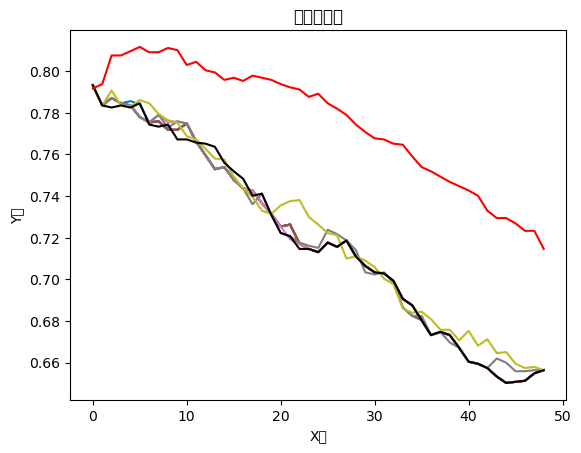

In [42]:
import matplotlib.pyplot as plt

fea_num=[i for i in range(49)]

# 创建图形
plt.plot(fea_num, aver_mean_lis1)
plt.plot(fea_num, aver_mean_lis2)
plt.plot(fea_num, aver_mean_lis3)
plt.plot(fea_num, aver_mean_lis4)
plt.plot(fea_num, aver_mean_lis5)
plt.plot(fea_num, aver_mean_lis6)
plt.plot(fea_num, aver_mean_lis7)
plt.plot(fea_num, aver_mean_lis8)
plt.plot(fea_num, aver_mean_lis9)
plt.plot(fea_num, rfe_SVM_aver_mean_lis,color="black")
plt.plot(fea_num, relief_SVM_aver_mean_lis,color="red")



# 添加标题和标签
plt.title('简单折线图')
plt.xlabel('X轴')
plt.ylabel('Y轴')

# 显示图形
plt.show()

In [73]:
yanghe_accuracy=[]
yanghe_accuracy.append(aver_mean_lis1)
yanghe_accuracy.append(aver_mean_lis2)
yanghe_accuracy.append(aver_mean_lis3)
yanghe_accuracy.append(aver_mean_lis4)
yanghe_accuracy.append(aver_mean_lis5)
yanghe_accuracy.append(aver_mean_lis6)
yanghe_accuracy.append(aver_mean_lis7)
yanghe_accuracy.append(aver_mean_lis8)
yanghe_accuracy.append(aver_mean_lis9)
yanghe_accuracy.append(rfe_SVM_aver_mean_lis)
yanghe_accuracy.append(relief_SVM_aver_mean_lis)

In [74]:
colu=[i for i in range(1,50)]
yanghe_acurracy_dataframe=pd.DataFrame(columns=colu,data=np.array(yanghe_accuracy))
yanghe_acurracy_dataframe.to_csv("yanghe_accuracy.csv")

In [75]:
yanghe_F_measure=[]
yanghe_F_measure.append(F_measure_lis1)
yanghe_F_measure.append(F_measure_lis2)
yanghe_F_measure.append(F_measure_lis3)
yanghe_F_measure.append(F_measure_lis4)
yanghe_F_measure.append(F_measure_lis5)
yanghe_F_measure.append(F_measure_lis6)
yanghe_F_measure.append(F_measure_lis7)
yanghe_F_measure.append(F_measure_lis8)
yanghe_F_measure.append(F_measure_lis9)
yanghe_F_measure.append(rfe_SVM_F_measure_lis)
yanghe_F_measure.append(relief_SVM_F_measure_lis)

In [76]:
colu=[i for i in range(1,50)]
yanghe_F_measure_dataframe=pd.DataFrame(columns=colu,data=np.array(yanghe_F_measure))
yanghe_F_measure_dataframe.to_csv("yanghe_F_measure.csv")